<a href="https://colab.research.google.com/github/omiyawaki/miyawaki-2025-nonmonotonic-moist-adiabat/blob/main/Figure_A1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<>:180: SyntaxWarning: invalid escape sequence '\D'
<>:195: SyntaxWarning: invalid escape sequence '\D'
<>:180: SyntaxWarning: invalid escape sequence '\D'
<>:195: SyntaxWarning: invalid escape sequence '\D'
/var/folders/vt/gqrlflhj10b1g04_6pcq_q3r0000gn/T/ipykernel_32199/4281979826.py:180: SyntaxWarning: invalid escape sequence '\D'
  ax_a.set_xlabel('Warming $\Delta T$ (K)'); ax_a.set_ylabel('Pressure (hPa)')
/var/folders/vt/gqrlflhj10b1g04_6pcq_q3r0000gn/T/ipykernel_32199/4281979826.py:195: SyntaxWarning: invalid escape sequence '\D'
  ax_b.set_xlabel('Surface Temperature (K)'); ax_b.set_ylabel('Warming $\Delta T$ (K)')


--- Starting Main Calculation for Appendix Figure A1 ---
Processing Ts = 280.0 K...
Processing Ts = 282.0 K...
Processing Ts = 284.0 K...
Processing Ts = 286.0 K...
Processing Ts = 288.0 K...
Processing Ts = 290.0 K...
Processing Ts = 292.0 K...
Processing Ts = 294.0 K...
Processing Ts = 296.0 K...
Processing Ts = 298.0 K...
Processing Ts = 300.0 K...
Processing Ts = 302.0 K...
Processing Ts = 304.0 K...
Processing Ts = 306.0 K...
Processing Ts = 308.0 K...
Processing Ts = 310.0 K...
Processing Ts = 312.0 K...
Processing Ts = 314.0 K...
Processing Ts = 316.0 K...
Processing Ts = 318.0 K...
Processing Ts = 320.0 K...

--- Calculation Finished in 0.25 seconds ---

--- Processing Data for Figure A1 ---
--- Generating Figure A1 ---


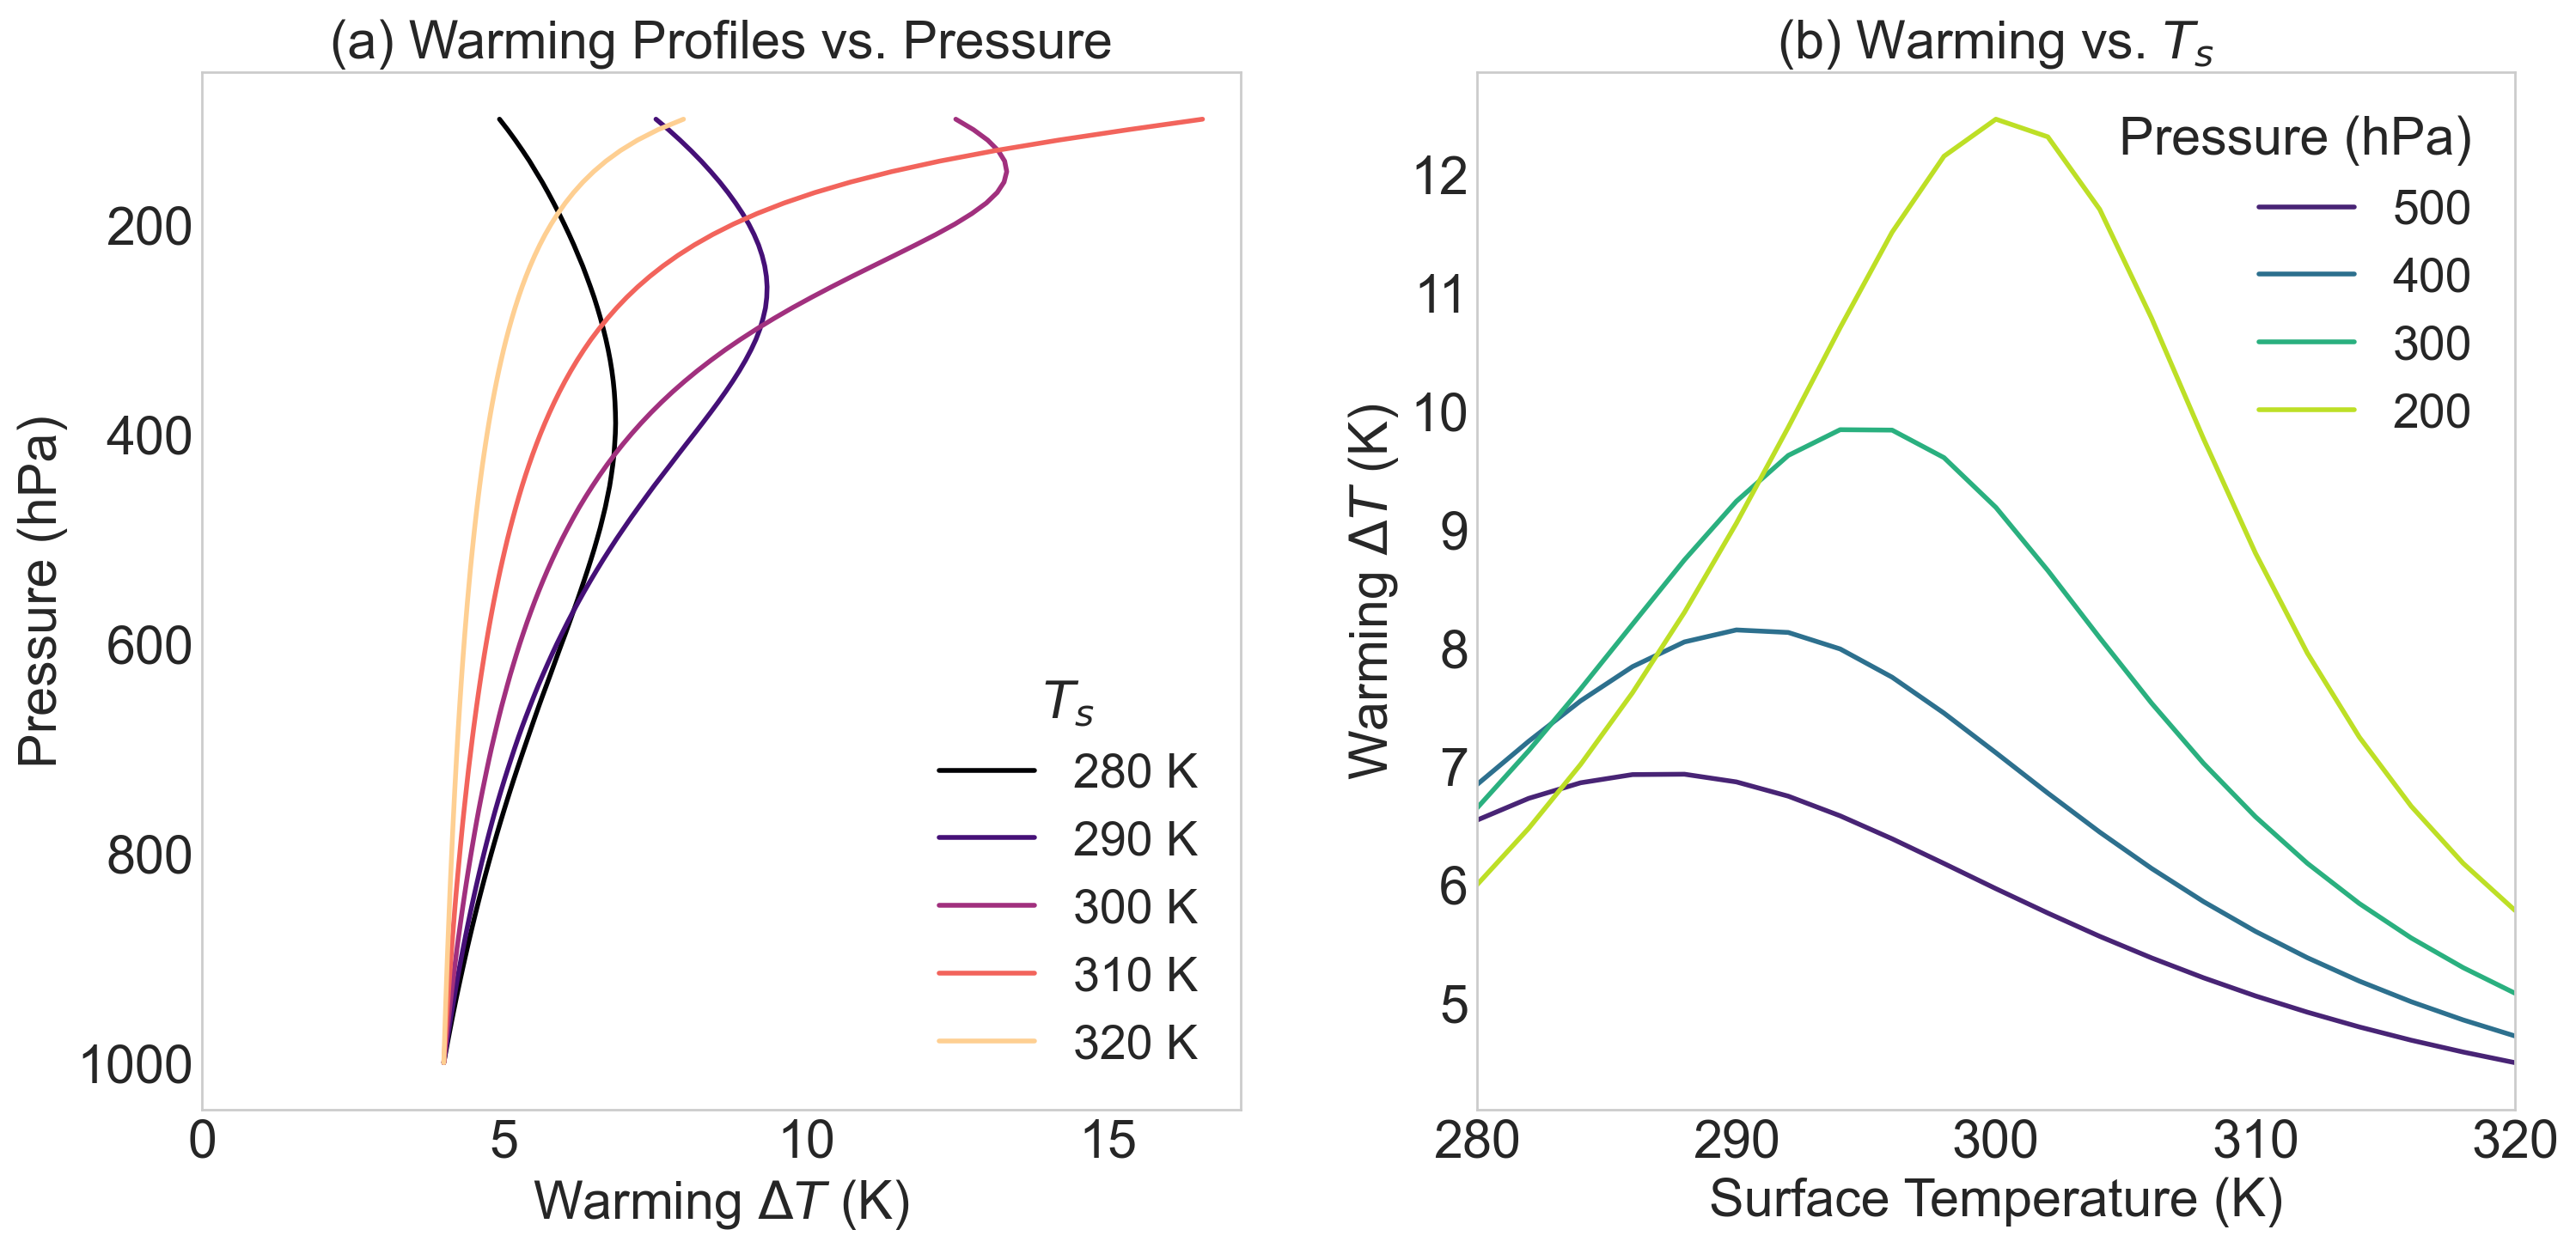

Figure A1 saved as fig-a1.png

Script finished.


In [1]:
# ==============================================================================
# SCRIPT TO CALCULATE AND PLOT APPENDIX FIGURE A1: WARMING IN PRESSURE COORDS
#
# This script performs the following actions:
# 1. Defines thermodynamic constants and functions for a moist atmosphere.
# 2. Implements a function to calculate a moist adiabatic temperature profile
#    by conserving Moist Static Energy (MSE) at each vertical step.
# 3. Runs this function for a range of surface temperatures (Ts) and for
#    a perturbed state (Ts + 4K) to compute the warming profile (Delta T).
# 4. Processes the results by interpolating warming onto a pressure grid.
# 5. Creates Figure A1, a two-panel plot showing the warming profiles and
#    non-monotonic warming curves in pressure coordinates.
# ==============================================================================

# For sharper inline plots in Jupyter environments
%config InlineBackend.figure_format = 'retina'

import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import root_scalar
from scipy import constants
from scipy.interpolate import interp1d
import time

# --- Physical Constants ---
g = constants.g
cpd = 1005.7
Rd = 287.05
Rv = 461.5
epsilon = Rd / Rv
P0 = 100000.0
Lv_const = 2.501e6

# --- Thermodynamic Functions ---

def saturation_vapor_pressure(T):
    """
    Calculates saturation vapor pressure (es) over liquid water using the
    formula from Bolton (1980) (in Pa).
    """
    T_celsius = T - 273.15
    es_hPa = 6.112 * np.exp((17.67 * T_celsius) / (T_celsius + 243.5))
    return es_hPa * 100.0

def saturation_specific_humidity(p, T):
    """Calculates saturation specific humidity (qs) over water (kg/kg)."""
    es = saturation_vapor_pressure(T)
    es = np.minimum(es, p * 0.99)
    p_minus_es_approx = p - (1.0 - epsilon) * es
    denominator = np.maximum(p_minus_es_approx, 1e-3)
    qs = epsilon * es / denominator
    return np.maximum(qs, 0.0)

def calculate_mse(T, p, z):
    """
    Calculates Moist Static Energy (MSE) using the approximation
    MSE = cpd*T + g*z + Lv*qs (J/kg).
    """
    qs = saturation_specific_humidity(p, T)
    mse = cpd * T + g * z + Lv_const * qs
    return mse

def virtual_temperature(T, p):
    """Calculates virtual temperature (Tv) assuming saturation."""
    qs = saturation_specific_humidity(p, T)
    Tv = T * (1.0 + (1.0 / epsilon - 1.0) * qs)
    return np.maximum(Tv, 10.0)

# --- Profile Calculation Function ---

def calculate_moist_adiabatic_profile(T_surf, p_surf, z_max, dz):
    """
    Calculates temperature and pressure profiles by conserving MSE.
    Returns z, T, and p profiles.
    """
    n_steps = int(z_max / dz) + 1
    z_profile = np.linspace(0, z_max, n_steps)
    T_profile = np.full(n_steps, np.nan)
    p_profile = np.full(n_steps, np.nan)

    T_profile[0] = T_surf
    p_profile[0] = p_surf
    mse_conserved = calculate_mse(T_profile[0], p_profile[0], 0.0)

    for i in range(n_steps - 1):
        z_curr, T_curr, p_curr = z_profile[i], T_profile[i], p_profile[i]
        z_next = z_profile[i+1]

        if np.isnan(T_curr) or p_curr <= 0:
            break

        Tv_curr = virtual_temperature(T_curr, p_curr)
        scale_height = (Rd * Tv_curr) / g
        p_next = p_curr * np.exp(-dz / scale_height)
        if p_next <= 0:
            break

        def mse_residual(T_guess):
            return calculate_mse(T_guess, p_next, z_next) - mse_conserved

        try:
            bracket = [50.0, T_curr]
            if mse_residual(bracket[0]) * mse_residual(bracket[1]) > 0:
                break
            sol = root_scalar(mse_residual, bracket=bracket, method='brentq', xtol=1e-3)
            if sol.converged:
                T_profile[i+1] = sol.root
                p_profile[i+1] = p_next
            else:
                break
        except (ValueError, RuntimeError):
            break

    valid_indices = ~np.isnan(T_profile)
    return z_profile[valid_indices], T_profile[valid_indices], p_profile[valid_indices]

# --- Main Calculation Block ---
print("--- Starting Main Calculation for Appendix Figure A1 ---")
start_time = time.time()

# Parameters
T_surf_values = np.arange(280, 320.1, 2.0)
p_surf_pa = 100000.0
z_max_m = 25000.0 # Calculate to high altitude to ensure p-levels are reached
dz_m = 100.0
delta_T_surf = 4.0

profiles = {}
for T_surf in T_surf_values:
    print(f"Processing Ts = {T_surf:.1f} K...")
    z1, T1, p1 = calculate_moist_adiabatic_profile(T_surf, p_surf_pa, z_max_m, dz_m)
    z2, T2, p2 = calculate_moist_adiabatic_profile(T_surf + delta_T_surf, p_surf_pa, z_max_m, dz_m)

    if z1 is not None and len(z1) > 2 and z2 is not None and len(z2) > 2:
        profiles[T_surf] = {'base': {'z': z1, 'T': T1, 'p': p1}, 'pert': {'z': z2, 'T': T2, 'p': p2}}
    else:
        print(f"  -> Failed to generate complete profiles for Ts = {T_surf:.1f} K.")

print(f"\n--- Calculation Finished in {time.time() - start_time:.2f} seconds ---\n")

# --- Data Processing for Plot ---
print("--- Processing Data for Figure A1 ---")
p_grid_hpa = np.arange(1000, 99, -10)
delta_T_on_p = {}

for T_surf, data in profiles.items():
    # Ensure pressure is monotonically decreasing for interpolation
    valid1_p = ~np.isnan(data['base']['p']) & (np.diff(data['base']['p'], prepend=p_surf_pa+1) < 0)
    valid2_p = ~np.isnan(data['pert']['p']) & (np.diff(data['pert']['p'], prepend=p_surf_pa+1) < 0)

    if np.sum(valid1_p) > 2 and np.sum(valid2_p) > 2:
        interp_T1_p = interp1d(data['base']['p'][valid1_p], data['base']['T'][valid1_p], kind='linear', bounds_error=False, fill_value=np.nan)
        interp_T2_p = interp1d(data['pert']['p'][valid2_p], data['pert']['T'][valid2_p], kind='linear', bounds_error=False, fill_value=np.nan)
        T1_p = interp_T1_p(p_grid_hpa * 100) # convert hPa to Pa for interpolation
        T2_p = interp_T2_p(p_grid_hpa * 100)
        delta_T_on_p[T_surf] = T2_p - T1_p

# --- Plotting Figure A1 ---
print("--- Generating Figure A1 ---")
plt.style.use('seaborn-v0_8-whitegrid')

base_fontsize = 22
plt.rcParams.update({
    'font.size': base_fontsize, 'axes.titlesize': base_fontsize, 'axes.labelsize': base_fontsize,
    'xtick.labelsize': base_fontsize, 'ytick.labelsize': base_fontsize, 'legend.fontsize': base_fontsize-2,
    'figure.titlesize': base_fontsize + 2
})

fig_a1, axes = plt.subplots(1, 2, figsize=(16, 8))
cmap_T = plt.get_cmap('magma')
cmap_level = plt.get_cmap('viridis')

# Panel (a): Vertical Warming Profiles vs. Pressure
ax_a = axes[0]
T_plot_values = np.arange(280, 320.1, 10.0)
colors_a = cmap_T(np.linspace(0, 0.9, len(T_plot_values)))
for i, T_surf in enumerate(T_plot_values):
    if T_surf in delta_T_on_p:
        ax_a.plot(delta_T_on_p[T_surf], p_grid_hpa, color=colors_a[i], label=f'{T_surf:.0f} K', linewidth=2)
ax_a.set_xlabel('Warming $\Delta T$ (K)'); ax_a.set_ylabel('Pressure (hPa)')
ax_a.set_title('(a) Warming Profiles vs. Pressure'); ax_a.legend(title='$T_{s}$', title_fontsize=base_fontsize)
ax_a.grid(False); ax_a.invert_yaxis(); ax_a.set_xlim(left=0)
ax_a.set_box_aspect(1)

# Panel (b): Non-monotonic Warming vs. Ts at fixed Pressure
ax_b = axes[1]
p_levels_hpa = [500, 400, 300, 200]
colors_b = cmap_level(np.linspace(0.1, 0.9, len(p_levels_hpa)))
sorted_surfs = sorted(delta_T_on_p.keys())
for i, p_hpa in enumerate(p_levels_hpa):
    p_idx = np.argmin(np.abs(p_grid_hpa - p_hpa))
    valid_surfs = [T for T in sorted_surfs if T in delta_T_on_p and p_idx < len(delta_T_on_p[T]) and np.isfinite(delta_T_on_p[T][p_idx])]
    warming_at_p = [delta_T_on_p[T][p_idx] for T in valid_surfs]
    ax_b.plot(valid_surfs, warming_at_p, linestyle='-', color=colors_b[i], label=f'{p_hpa}', linewidth=2)
ax_b.set_xlabel('Surface Temperature (K)'); ax_b.set_ylabel('Warming $\Delta T$ (K)')
ax_b.set_title('(b) Warming vs. $T_{s}$');

legend = ax_b.legend(title='Pressure (hPa)', title_fontsize=base_fontsize, loc='upper right', alignment='right')

ax_b.grid(False); ax_b.set_xlim(280, 320)
ax_b.set_box_aspect(1)

plt.tight_layout(pad=2.0)

figA1_filename = "fig-a1.png"
plt.savefig(figA1_filename, dpi=300, bbox_inches='tight')
plt.show()
print(f"Figure A1 saved as {figA1_filename}")

print("\nScript finished.")
